# 인공지능은 객관적일까?

워드 임베딩에 숨어 있는 편향성을 측정하는 대표적인 방법론인 Word Embedding Association Test (WEAT) 라는 기법을 알아보자.

이를 활용해 우리가 학습시킨 Word2Vec 임베딩 내의 편향성을 측정해 보면서 실제로 이 방법론이 우리 머리 속에 있는 편향성을 잘 반영하는지도 살펴보자.

- 데이터의 편향성에 대한 문제의식을 갖는다.
- 임베딩 모델의 편향성을 체크하는 방법 중 하나인 Word Embedding Association Test (WEAT)를 알아본다.
- WEAT 수식의 의미를 이해하고 이를 구현해본다.
- pre-train된 모델을 불러와서 WEAT score를 구해본다.

### 워드 임베딩 속의 편향성

'프로그래머'라는 단어에서 남성의 이미지가, '가정주부'라는 단어에서 여성의 이미지가 떠오르시나요? 분명 프로그래머와 가정주부는 젠더 중립적인 단어임에도 불구하고 우리의 무의식 속에서 어쩌면 정말 그렇게 느끼고 있을지도 모르겠군요.

우리가 가지고 있을지도 모를 편견이 워드 임베딩 속 벡터들에 고스란히 반영되어 있었다는 것을 보여 주는 좋은 예시다.

### WEAT(Word Embedding Association Test)

워드 임베딩 벡터들 간에는 의미적인 유사도 거리를 정량적으로 측정할 수 있다.

그렇다면 워드 임베딩에 내포된 편향성도 정량적으로 측정할 방법은 없을까?  
https://arxiv.org/pdf/1607.06520.pdf 이 논문이 발표되자마자 몇 달도 되지 않아 그런 방법이 제안되었다.

Word Embedding Association Test (WEAT) 는 임베딩 모델의 편향을 측정하는 방식 중 하나로, 2016년에 Aylin Caliskan이 제안했다.  
https://arxiv.org/pdf/1608.07187.pdf

#### 편향이라는 걸 어떻게 정량적으로 정의할 수 있을까?

남자(Male)가 Scientist에, 여자(Female)가 Art에 가깝다라는 편향을 Word Embedding 상에서 정의하는 방법을 생각해 보자.

만약 Science와 Art가 모두 완벽히 젠더 중립적이라면, Word Embedding 상에서도 Science, Art가 Male, Female의 두 단어와의 거리가 동일해야 할 것이다.  
그러나 만약 정말 편향이 존재한다면, Science와 Male 간의 거리가 Science와 Female 간의 거리보다 가깝고, 거꾸로 Art와 Male 간의 거리는 Art와 Female간의 거리보다 멀어야 할 것이다.

하지만 고작 4개의 단어 사이의 거리를 계산하는 방식으로 워드 임베딩 공간상에 편향이 존재한다고 단정할 수 있을까?

그래서 WEAT는 Male과 Female, Science와 Art라는 개념을 가장 잘 대표하는 단어들을 여러 개 골라 단어 셋(set)을 만든다.  
단어 셋에 속한 모든 단어들끼리의 편향성을 전부 계산해서 평균을 수치화해보면 보다 명확하게 개념적인 편향성이 존재함을 밝힐 수 있지 않을까?

이러한 단어 셋을 WEAT에서는 각각 target 과 attribute 라고 한다.

Science를 대표하는 target 단어 셋 X와 Art를 대표하는 target 단어 셋 Y가 있다고 하면 X-Y 셋을 통한 개념축 하나가 얻어진다.  
Male을 대표하는 attribute 단어 셋 A와 Female을 대표하는 attribute 단어 셋 B가 있다면 A-B 셋을 통한 개념축 하나가 또 얻어진다.  
편향성이 없다면, X에 속한 단어들은 A에 속한 단어들과의 거리와 B에 속한 단어들과의 거리가 별 차이가 없어야 한다.

이 WEAT score 의 절대값이 클수록 두 개념축 사이의 편향성이 크게 나타나는 것으로 해석할 수 있다.

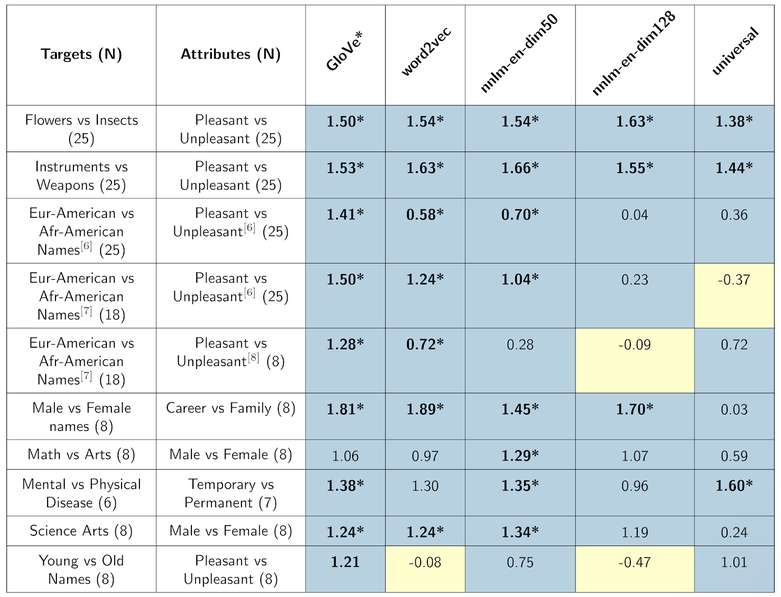

In [1]:
from IPython.display import Image
Image(filename='capture/08_weat_result_by_google.png') 

위 표에서 파란색은 사람의 편향과 같은 경우이고, 노란색은 사람의 편향과 반대인 경우를 의미한다.

꽃과 벌레, 유쾌함과 불쾌함 등 누구나 동의할만한 편향성이 존재하는 경우엔 대부분의 경우 WEAT score의 절댓값이 1.5 이상으로 뚜렷한 편향성 수치가 나오는 것을 볼 수 있다.

### WEAT 구현하기

In [2]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

print("슝~")

슝~


우선 두 개의 target 단어 셋 X, Y와 두 개의 attribute 단어 셋 A, B를 정의한다.  
단어 셋을 정할 때는 두 개의 target 셋의 크기가 같아야 하고, 두 개의 attribute 셋의 크기가 같아야 한다.

- targets
  - X set(꽃) : 장미, 튤립, 백합, 데이지
  - Y set(곤충) : 거미, 모기, 파리, 메뚜기
- attributes
  - A set(유쾌) : 사랑, 행복, 웃음
  - B set(불쾌) : 재난, 고통, 증오

위 단어들의 임베딩 결과가 다음과 같다고 해보자.

In [3]:
target_X = {
    '장미': [4.1, 1.2, -2.4, 0.5, 4.1],
    '튤립': [3.1, 0.5, 3.6, 1.7, 5.8],
    '백합': [2.9, -1.3, 0.4, 1.1, 3.7],
    '데이지': [5.4, 2.5, 4.6, -1.0, 3.6]
}
target_Y = {
    '거미': [-1.5, 0.2, -0.6, -4.6, -5.3],
    '모기': [0.4, 0.7, -1.9, -4.5, -2.9],
    '파리': [0.9, 1.4, -2.3, -3.9, -4.7],
    '메뚜기': [0.7, 0.9, -0.4, -4.1, -3.9]
}
attribute_A = {
    '사랑':[2.8,  4.2, 4.3,  0.3, 5.0],
    '행복':[3.8,  3. , -1.2,  4.4, 4.9],
    '웃음':[3.7, -0.3,  1.2, -2.5, 3.9]
}
attribute_B = {
    '재난': [-0.2, -2.8, -4.7, -4.3, -4.7],
    '고통': [-4.5, -2.1,  -3.8, -3.6, -3.1],
    '증오': [-3.6, -3.3, -3.5,  -3.7, -4.4]
}

In [4]:
X = np.array([v for v in target_X.values()])
Y = np.array([v for v in target_Y.values()])
print(X)
print(Y)

[[ 4.1  1.2 -2.4  0.5  4.1]
 [ 3.1  0.5  3.6  1.7  5.8]
 [ 2.9 -1.3  0.4  1.1  3.7]
 [ 5.4  2.5  4.6 -1.   3.6]]
[[-1.5  0.2 -0.6 -4.6 -5.3]
 [ 0.4  0.7 -1.9 -4.5 -2.9]
 [ 0.9  1.4 -2.3 -3.9 -4.7]
 [ 0.7  0.9 -0.4 -4.1 -3.9]]


In [5]:
A = np.array([v for v in attribute_A.values()])
B = np.array([v for v in attribute_B.values()])
print(A)
print(B)

[[ 2.8  4.2  4.3  0.3  5. ]
 [ 3.8  3.  -1.2  4.4  4.9]
 [ 3.7 -0.3  1.2 -2.5  3.9]]
[[-0.2 -2.8 -4.7 -4.3 -4.7]
 [-4.5 -2.1 -3.8 -3.6 -3.1]
 [-3.6 -3.3 -3.5 -3.7 -4.4]]


In [8]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [9]:
print(s(target_X['장미'], A, B))

0.6457646122337399


WEAT score값이 양수이므로, target_X에 있는 '장미'라는 단어는 attribute_B(불쾌)보다 attribute_A(유쾌)와 더 가깝다는 것을 알 수 있다. 

target_Y에 있는 '거미'와 attribute_A, attribute_B와의 관계도 계산해보자.

In [7]:
print(s(target_Y['거미'], A, B))

-0.794002342033094


위와 반대로 WEAT score가 음수가 나왔으므로, '거미'는 attribute_B와 더 가깝다는 것을 알 수 있다.

그럼 target_X와 attribute_A, attribute_B 사의의 평균값, 그리고 target_Y와 attribute_A, attribute_B 사의의 평균값은 어떻게 될까?

In [11]:
print(s(X, A, B))
print(round(np.mean(s(X, A, B)), 3))

[0.29551989 0.51723181 0.26499096 0.50924109]
0.397


target_X와 attribute_A, attribute_B 사이의 평균값은 0.397 이다.

In [13]:
print(s(Y, A, B))
print(round(np.mean(s(Y, A, B)), 3))

[-0.44713039 -0.28310853 -0.33144878 -0.26030641]
-0.33


target_Y와 attribute_A, attribute_B 사이의 평균값은 -0.33 이다.

WEAT score의 수식 전체를 코드로 나타내 보자.

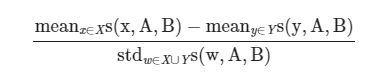

In [14]:
from IPython.display import Image
Image(filename='capture/08_weat_formula.png') 

In [15]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

print(round(weat_score(X, Y, A, B), 3))

1.932


WEAT score가 매우 높게 나온 것을 알 수 있다. 

즉, 꽃은 유쾌한 단어와 상대적으로 가깝고, 곤충은 불쾌한 단어와 가깝다는 것을 수치적으로 확인할 수 있다.

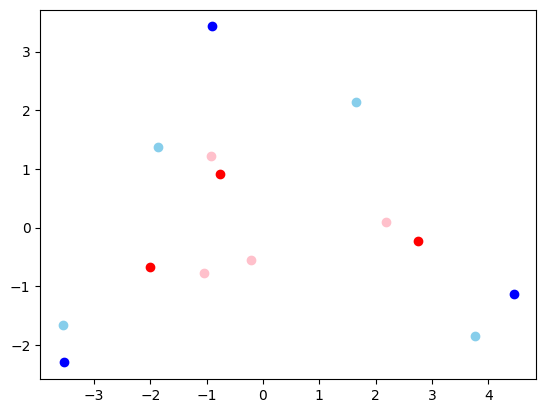

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')

시각화하면 위와 같다.  
파란색 점(A)과 하늘색 점(X)이 가깝고, 빨간색 점(B)과 분홍색 점(Y)이 가깝게 표현된 것을 확인할 수 있다.

### 사전학습된 Wod Embedding에 WEAT 적용

이제 실제 pretrain된 임베딩 모델을 이용하여 계산해보자. 구글에서 학습한 모델을 사용해보도록 하겠다.

GoogleNews-vectors-negative300.bin.gz 다운로드 (1.5G)  
https://drive.google.com/u/0/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download

In [17]:
!dir weat

 D 드라이브의 볼륨: DATA
 볼륨 일련 번호: 3A3D-9FD4

 d:\Study\NotebookProjects\modoo-nlp\weat 디렉터리

2022-11-17  오후 07:41    <DIR>          .
2022-11-17  오후 07:41    <DIR>          ..
2013-12-12  오전 09:12     3,644,258,522 GoogleNews-vectors-negative300.bin
2022-11-17  오후 07:40     1,647,046,227 GoogleNews-vectors-negative300.bin.gz
               2개 파일       5,291,304,749 바이트
               2개 디렉터리  109,319,897,088 바이트 남음


In [18]:
import os

data_dir = './weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

from gensim.models import KeyedVectors

# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용할 수 있습니다. 
# w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True)

In [19]:
w2v

In [20]:
# w2v에 있는 단어 개수와 벡터 크기
# print(len(w2v.vocab))   # Gensim 3.X 버전까지는 w2v.vocab을 직접 접근할 수 있습니다. 
print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)

3000000
300
(3000000, 300)


w2v에는 limit으로 지정한 갯수(디폴트는 3,000,000개)의 단어가 있고, 각 단어는 300차원을 갖는다는 것을 알 수 있다.

In [21]:
# happy 라는 단어의 벡터
w2v['happy']

array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

In [22]:
# happy 와 유사한 단어
w2v.most_similar(positive=['happy'])

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

In [23]:
w2v.most_similar(positive=['family'])

[('relatives', 0.6662653088569641),
 ('familiy', 0.6517067551612854),
 ('families', 0.6252894997596741),
 ('siblings', 0.6140849590301514),
 ('friends', 0.6128394603729248),
 ('mother', 0.6065612435340881),
 ('fam_ily', 0.592625617980957),
 ('famiy', 0.5916981101036072),
 ('famliy', 0.584000289440155),
 ('aunt', 0.5811319947242737)]

In [24]:
w2v.most_similar(positive=['school'])

[('elementary', 0.7868632078170776),
 ('schools', 0.7411909103393555),
 ('shool', 0.6692329049110413),
 ('elementary_schools', 0.6597153544425964),
 ('kindergarten', 0.6529811024665833),
 ('eighth_grade', 0.6488089561462402),
 ('School', 0.6477997303009033),
 ('teacher', 0.63824063539505),
 ('students', 0.6301522850990295),
 ('classroom', 0.6281620264053345)]

이제 WEAT를 통해 이 모델의 편향성을 확인해보도록 하자.  
https://arxiv.org/pdf/1608.07187.pdf 에 있던 단어 셋으로 구성해보자.

In [25]:
target_X = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_Y = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.2624874

과학과 관련된 단어가 남성과 관련된 단어와 가깝고, 예술과 관련된 단어가 여성과 관련된 단어와 가깝게 나타났다.  
사람의 편향성을 실험하는 IAT 에서도 이와 같게 나타났다. 많은 사람이 가진 편향이 임베딩 모델에 반영되었다고 볼 수 있다.

이제 다른 셋을 구성해보자.

target_X는 인스턴트 식품들로 단어를 구성하였고 target_Y는 그 반대로 구성했다.  
attribute_A는 인스턴트를 의미하는 단어들로, attributes_B는 그 반대로 구성했다.

In [26]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_B = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.6909266

target 셋에 다른 attribute 셋을 만들어보자. 책과 뉴스로 해 보면?

In [27]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['book', 'essay', 'dictionary', 'magazine', 'novel']
attribute_B = ['news', 'report', 'statement', 'broadcast', 'word']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

-0.05137869

0 에 거의 가까운 값이다.

즉, 임베딩 모델이 판단하기에 어느 것끼리 가깝다고 말할 수 없는 것이라는 뜻이다.

In [28]:
#메모리를 다시 비워줍시다.
del w2v
print("삭제 완료")

삭제 완료


### 직접 만드는 Word Embedding에 WEAT 적용

지금까지는 제시된 모델과 단어들로 WEAT score를 구해보았다. 

이제 주어진 데이터로 다음과 같은 과정을 수행해보도록 하겠다.
- 형태소 분석기를 이용하여 품사가 명사인 경우, 해당 단어를 추출하기
- 추출된 결과로 embedding model 만들기
- TF/IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
- embedding model과 단어 셋으로 WEAT score 구해보기

#### 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

synopsis.txt(대략 17MB)에는 2001년부터 2019년 8월까지 제작된 영화들의 시놉시스 정보가 있다.

wget -p ./data/ https://d3s0tskafalll9.cloudfront.net/media/documents/synopsis.zip

In [33]:
!dir data\\synopsis

 D 드라이브의 볼륨: DATA
 볼륨 일련 번호: 3A3D-9FD4

 d:\Study\NotebookProjects\modoo-nlp\data\synopsis 디렉터리

2022-11-17  오후 07:55    <DIR>          .
2022-11-17  오후 07:55    <DIR>          ..
2020-10-18  오후 03:17        17,752,952 synopsis.txt
2020-10-18  오후 10:05         1,454,329 synopsis_action.txt
2020-10-18  오후 10:05           606,086 synopsis_adult.txt
2020-10-18  오후 10:05           125,859 synopsis_adventure.txt
2020-10-18  오후 10:05         1,638,647 synopsis_animation.txt
2020-10-18  오후 09:46         2,737,865 synopsis_art.txt
2020-10-18  오후 10:05         1,394,921 synopsis_comedy.txt
2020-10-18  오후 10:05           371,729 synopsis_crime.txt
2020-10-18  오후 10:05         2,017,337 synopsis_documentary.txt
2020-10-18  오후 10:05         5,151,492 synopsis_drama.txt
2020-10-18  오후 10:05           636,890 synopsis_etc.txt
2020-10-18  오후 10:05           106,163 synopsis_family.txt
2020-10-18  오후 10:05           159,187 synopsis_fantasy.txt
2020-10-18  오후 09:46        13,398,320 synopsis_gen.txt
2

In [37]:
# 몇 개만 확인해보자
import os

with open('./data/synopsis/synopsis.txt', 'r', encoding='UTF8') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

konlpy 패키지를 이용하여 품사가 명사인 경우만 남겨 tokenized 라는 변수명으로 저장해보자.

In [38]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
# with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r', encoding='UTF8') as file:
with open('./data/synopsis/synopsis.txt', 'r', encoding='UTF8') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [39]:
print(len(tokenized))

71156


#### 추출된 결과로 embedding model 만들기

In [40]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.8819548487663269),
 ('다큐멘터리', 0.8430690765380859),
 ('드라마', 0.8232410550117493),
 ('영화로', 0.779888391494751),
 ('형식', 0.7744728922843933),
 ('코미디', 0.7723042368888855),
 ('소재', 0.7667834758758545),
 ('주제', 0.7561047077178955),
 ('감동', 0.7500885725021362),
 ('영상', 0.7474194765090942)]

In [41]:
model.wv.most_similar(positive=['사랑'])

[('첫사랑', 0.7109848260879517),
 ('애정', 0.709472119808197),
 ('만남', 0.7091197967529297),
 ('행복', 0.7084718346595764),
 ('만인', 0.6956827640533447),
 ('이별', 0.6937273740768433),
 ('연애', 0.6776406168937683),
 ('진심', 0.6758056879043579),
 ('얄궂', 0.6755223274230957),
 ('가슴', 0.6741985082626343)]

In [42]:
model.wv.most_similar(positive=['연극'])

[('영화감독', 0.9126878380775452),
 ('오페라', 0.8903912901878357),
 ('각색', 0.885116457939148),
 ('대본', 0.8848315477371216),
 ('시나리오', 0.8803564310073853),
 ('영화로', 0.8768381476402283),
 ('무용', 0.8754971027374268),
 ('데뷔', 0.8752790093421936),
 ('뮤지컬', 0.8735204339027405),
 ('예술가', 0.8731828331947327)]

#### TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기

WEAT score를 구할 때 단어 셋을 만들어주어야 한다.  

targets_X, targets_Y, attribute_A, attribute_B를 만들어주어야 한다는 것이다.

이제 두 축을 어떤 기준으로 잡고, 해당 축의 어떤 항목을 사용할지 정해야 한다.

여기서는 두 축을
- 영화 장르
  - synopsis_SF.txt: SF
  - synopsis_family.txt: 가족
  - synopsis_art.txt: 공연
  - synopsis_horror.txt: 공포(호러)
  - synopsis_etc.txt: 기타
  - synopsis_documentary.txt: 다큐멘터리
  - synopsis_drama.txt: 드라마
  - synopsis_romance.txt: 멜로로맨스
  - synopsis_musical.txt: 뮤지컬
  - synopsis_mystery.txt: 미스터리
  - synopsis_crime.txt: 범죄
  - synopsis_historical.txt: 사극
  - synopsis_western.txt: 서부극(웨스턴)
  - synopsis_adult.txt: 성인물(에로)
  - synopsis_thriller.txt: 스릴러
  - synopsis_animation.txt: 애니메이션
  - synopsis_action.txt: 액션
  - synopsis_adventure.txt: 어드벤처
  - synopsis_war.txt: 전쟁
  - synopsis_comedy.txt: 코미디
  - synopsis_fantasy.txt: 판타지
- 영화 구분 (영화 구분 정보란 일반영화, 예술영화, 독립영화로 구분된 정보이다. KOBIS에서 제공한 정보를 기준으로 분류)
  - synopsis_art.txt : 예술영화
  - synopsis_gen.txt : 일반영화(상업영화)
  - 그 외는 독립영화
정보를 이용하겠다.

이번에는  
예술영화와 일반영화(상업영화)라는 영화구분을 target으로 삼고,  
드라마 장르와 액션 장르라는 장르구분을 attribute로 삼아 WEAT score를 계산해 보겠다. 

즉, 드라마 장르에는 예술영화적 성격이 강하고, 액션 장르에는 일반(상업)영화적 성격이 강할 것이라는 편향성이 워드 임베딩 상에 얼마나 나타나고 있는지를 측정해 보겠다는 것이다.

'synopsis_art.txt', 'synopsis_gen.txt' 두 파일을 읽고,  
위에서 했던 것과 마찬가지로 명사에 대해서만 추출하여 art, gen 변수에 할당하자.

In [45]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open('./data/synopsis/'+file_name, 'r', encoding='UTF8') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

print("슝~")

슝~


In [46]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


WEAT 계산을 위해서는 총 4개의 단어 셋 X, Y, A, B가 필요하다. 

예를 들면 예술영화라는 개념을 가장 잘 대표하는 단어들을 art_txt를 처리해서 만든 art라는 단어 리스트에서부터 골라내야 한다.  
이를 위해서 상식을 동원해서 적절한 단어를 골라낼 수도 있지만 보다 납득할 수 있는 보편적인 방법을 사용하는 것이 좋다.

코퍼스에서 자주 나타나는(TF가 높은) 단어이지만, 다른 코퍼스에까지 두루 걸쳐 나오지는 않는(IDF가 높은) 단어를 선정하고 싶으므로  
이번에는 단어 셋 구성을 위해 TF-IDF 방식을 사용하겠다. (단, 이 방식이 최선이라는 의미는 아니다.)

In [47]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [48]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


D:\Study\NotebookProjects\modoo-nlp\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [49]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출한다.

In [50]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [51]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [52]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


이번에는 장르별 대표 단어를 추출해 보자.

이번에는 드라마 장르와 액션 장르를 다루어 보려고 한다.  
그러나 드라마와 액션 단 2개의 장르만 고려하기보다는 여러 장르의 코퍼스를 두루 고려하는 것이 특정 장르를 대표하는 단어를 선택하는 데 더 유리할 것이다. 

이번에는 주요 장르 5개만 고려해 보자.

In [53]:
genre_txt = ['synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_action.txt', 'synopsis_comedy.txt', 'synopsis_war.txt', 'synopsis_horror.txt']
genre_name = ['드라마', '멜로로맨스', '액션', '코미디', '전쟁', '공포(호러)']

print("슝~")

슝~


In [54]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))
print("end")

synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
end


In [55]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(6, 33151)


In [56]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

드라마: 자신, 영화제, 그녀, 사람, 사랑, 위해, 영화, 시작, 국제, 남자, 친구, 이야기, 여자, 아버지, 엄마, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남자, 남편, 여자, 사람, 친구, 위해, 마음, 섹스, 결혼, 서로, 아내, 
액션: 위해, 자신, 시작, 조직, 사건, 사람, 그녀, 경찰, 전쟁, 친구, 모든, 목숨, 사실, 세계, 가족, 
코미디: 그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 
전쟁: 전쟁, 위해, 전투, 시작, 작전, 독일군, 부대, 독일, 윈터스, 자신, 사람, 공격, 임무, 연합군, 병사, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 남자, 가족, 영화, 하나, 


각 장르를 대표하는 단어들을 추출해보았다.  
중복된 것이 종종 있지만 art, gen 두 개의 단어 셋을 추출했을 때에 비해 적다.  

그러므로 중복을 체크해서 삭제하기보다 그대로 사용하겠다.

#### embedding model과 단어 셋으로 WEAT score 구해보기

이제 WEAT_score를 구해보자다.

traget_X는 art, target_Y는 gen, attribute_A는 '드라마', attribute_B는 '액션' 과 같이 정해줄 수 있다.

target_X 는 art, target_Y 는 gen으로 고정하고 attribute_A, attribute_B를 바꿔가면서 구해보자.  
구한 결과를 21x21 매트릭스 형태로 표현해서 matrix 라는 변수에 담아보자.

In [57]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print("슝~")

슝~


In [58]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

print("슝~")

슝~


matrix 를 채웠다. WEAT score 값을 확인해보자.

In [59]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

드라마 멜로로맨스 -0.8292932
드라마 액션 0.009189292
드라마 코미디 -0.03654442
드라마 전쟁 0.46712738
드라마 공포(호러) -0.19646098
멜로로맨스 액션 0.7775597
멜로로맨스 코미디 0.8890725
멜로로맨스 전쟁 0.8139459
멜로로맨스 공포(호러) 0.7369502
액션 코미디 -0.02985788
액션 전쟁 0.59426576
액션 공포(호러) -0.31645027
코미디 전쟁 0.53632504
코미디 공포(호러) -0.29304308
전쟁 공포(호러) -0.5951837


WEAT score가 0.8 이상, -0.8 이하의 경우만 해석해 보면 아래와 같다.

- 예술영화와 일반영화, 그리고 드라마와 멜로로맨스의 WEAT score의 의미를 해석해보면
  - 예술영화는 멜로로맨스, 일반영화는 드라마와 가깝다고 볼 수 있다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있다.
- 예술영화와 일반영화, 그리고 멜로로맨스와 코미디의 WEAT score의 의미를 해석해보면
  - 예술 영화는 멜로로맨스와 가깝고, 코디미는 일반 영화와 가깝다고 볼 수 있다.
- 예술영화와 일반영화, 그리고 멜로로맨스와 전쟁의 WEAT score의 의미를 해석해보면
  - 예술 영화는 멜로로맨스와 가깝고, 전쟁은 일반 영화와 가깝다고 볼 수 있다.

<AxesSubplot: >

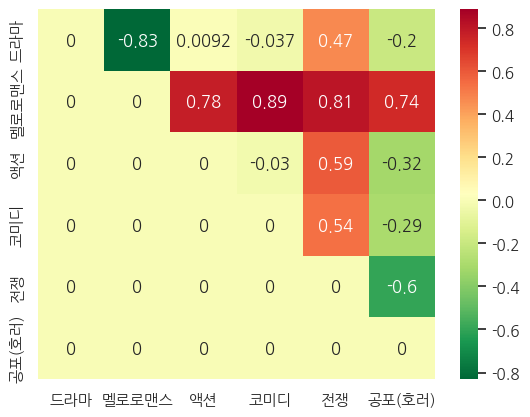

In [60]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

지금까지 word embedding model에 있는 편향성을 확인해보기 위해 WEAT score를 시도해보았다. 

이 학습을 통해 가진 데이터로 word embedding model을 만들 수 있고, 이 모델이 특정 분야에 대해 편향이 되어있는지 확인해볼 수 있게 되었다.